In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import bayesflow as bf
import tensorflow as tf

from functools import partial
from matplotlib.animation import FuncAnimation
from IPython.display import HTML




C:\Users\Gerald Wong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\bayesflow\trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Amortized Posterior Estimation for Complex Agent-Based Model
**Collective Motion with BayesFlow** 

In [25]:
## Constants

# Physical dimensions for simulation (in meters)
width = 8
height = 10

# Number of agents
num_agents = 12

# Maximum speed and force
max_speed = 1.5  # m/s
max_force = 0.03  # m/s^2

# Perception radii (in meters)
alignment_radius = 2.5
cohesion_radius = 5.0
separation_radius = 1.0

In [19]:
PARAM_NAMES = [
    r"$r_a$",    # Alignment radius
    r"$r_c$",    # Cohesion radius
    r"$r_s$",    # Separation radius
    r"$v_{\max}$",    # Max speed
    r"$F_{\max}$",    # Mac force
    r"$k_a$",
    r"$k_c$",
    r"$k_s$",
]

### Simulator

In [3]:
class Agent:
    def __init__(self, x, y, angle):
        self.position = np.array([x, y], dtype=float)
        self.velocity = np.array([np.cos(angle), np.sin(angle)], dtype=float)
        self.acceleration = np.zeros(2, dtype=float)

    def apply_force(self, force):
        self.acceleration += force

    def update(self):
        self.velocity += self.acceleration
        speed = np.linalg.norm(self.velocity)
        if speed > max_speed:
            self.velocity = (self.velocity / speed) * max_speed
        self.position += self.velocity
        self.acceleration *= 0

        # Wrap around the screen
        self.position = self.position % np.array([width, height])

        return self.position, self.velocity

    def align(self, agents, alignment_radius=2.5):
        steering = np.zeros(2)
        total = 0
        for agent in agents:
            if agent != self:
                distance = np.linalg.norm(self.position - agent.position)
                if distance < alignment_radius:
                    steering += agent.velocity
                    total += 1
        if total > 0:
            steering /= total
            steering = self.set_magnitude(steering, max_speed) - self.velocity
            steering = self.limit(steering, max_force)
        return steering

    def cohesion(self, agents, cohesion_radius=5.0):
        steering = np.zeros(2)
        total = 0
        for agent in agents:
            if agent != self:
                distance = np.linalg.norm(self.position - agent.position)
                if distance < cohesion_radius:
                    steering += agent.position
                    total += 1
        if total > 0:
            steering /= total
            steering -= self.position
            steering = self.set_magnitude(steering, max_speed) - self.velocity
            steering = self.limit(steering, max_force)
        return steering

    def separation(self, agents, separation_radius=1.0):
        steering = np.zeros(2)
        total = 0
        for agent in agents:
            if agent != self:
                distance = np.linalg.norm(self.position - agent.position)
                if distance < separation_radius:
                    diff = self.position - agent.position
                    if distance > 0:
                        diff /= distance  # Weight by distance
                    steering += diff
                    total += 1
        if total > 0:
            steering /= total
        if np.linalg.norm(steering) > 0:
            steering = self.set_magnitude(steering, max_speed) - self.velocity
            steering = self.limit(steering, max_force)
        return steering

    def flock_with(self, agents, radii):

        alignment_radius = radii[0]
        cohesion_radius = radii[1]
        separation_radius = radii[2]

        alignment = self.align(agents, alignment_radius)
        cohesion = self.cohesion(agents, cohesion_radius)
        separation = self.separation(agents, separation_radius)

        self.apply_force(alignment)
        self.apply_force(cohesion)
        self.apply_force(separation)

    @staticmethod
    def set_magnitude(vector, magnitude):
        norm = np.linalg.norm(vector)
        if norm == 0:
            return vector
        return vector * (magnitude / norm)

    @staticmethod
    def limit(vector, max_value):
        norm = np.linalg.norm(vector)
        if norm > max_value:
            return vector * (max_value / norm)
        return vector

In [28]:
# Initialize agents
agents = [Agent(
    np.random.uniform(0, width), 
    np.random.uniform(0, height),
    np.random.uniform(0, 2 * np.pi)
) for _ in range(num_agents)]
data = [[agent.position, agent.velocity] for agent in agents]
data

[[array([4.30562877, 8.80184018]), array([-0.29693827, -0.95489668])],
 [array([0.72571431, 0.93185219]), array([ 0.71065417, -0.7035415 ])],
 [array([0.08333572, 3.55536498]), array([-0.07579179,  0.99712367])],
 [array([3.55238312, 2.26062623]), array([-0.86364782,  0.50409568])],
 [array([4.99450858, 5.1410714 ]), array([-0.75301561, -0.65800265])],
 [array([5.77589067, 9.06864654]), array([ 0.21547997, -0.97650826])],
 [array([2.99494869, 7.7748469 ]), array([-0.85598291,  0.51700411])],
 [array([7.98136083, 3.07911493]), array([-0.73283779, -0.68040339])],
 [array([6.4793165 , 9.81726141]), array([0.78100975, 0.62451883])],
 [array([1.18957124, 0.58727752]), array([ 0.70983558, -0.70436741])],
 [array([3.15012392, 2.14436236]), array([0.18840004, 0.98209237])],
 [array([5.06970155, 2.86183188]), array([-0.77162746,  0.63607473])]]

In [ ]:
def simulator_fun(theta, num_timesteps=200, num_agents=6, rng=None):
    
    if rng is None:
        rng = np.random.default_rng()

    radii = theta[0:3]

    def initialize_agents(
        width=8, height=10, num_agents=num_agents, rng=rng):
        agents = [Agent(
            rng.uniform(0, width),      # x
            rng.uniform(0, height),     # y
            rng.uniform(0, 2 * np.pi)   # angle
        ) for _ in range(num_agents)]
        return [[agent.position, agent.velocity] for agent in agents]
    
    positions  = np.zeros((num_timesteps+1, num_agents, 2))
    directions = np.zeros((num_timesteps+1, num_agents, 2))

    for agent in agents:
        agent.flock_with(agents)
        agent.update()

    """WIP"""

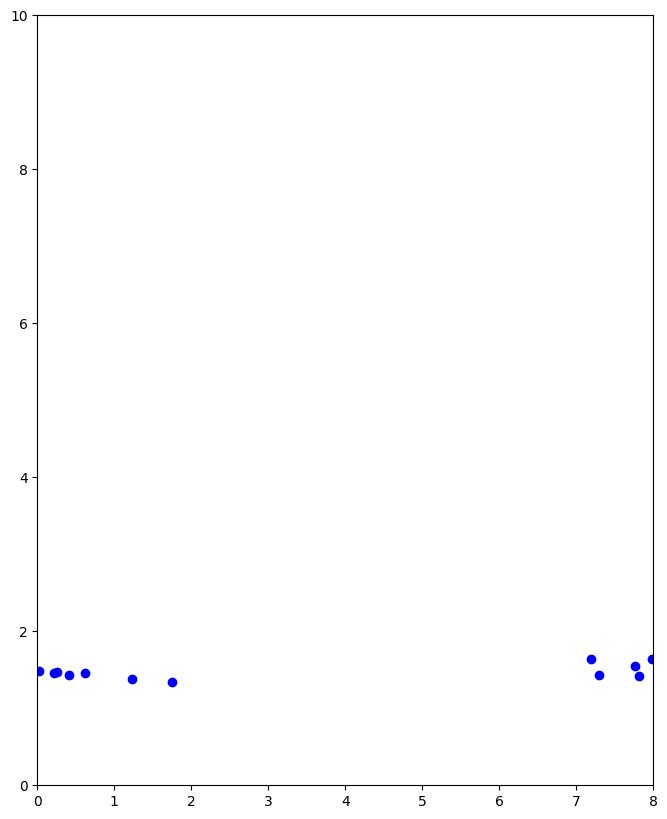

In [31]:
# Animation update function
def update(frame):
    plt.clf()
    for agent in agents:
        agent.flock_with(agents, radii=[alignment_radius, cohesion_radius, separation_radius])
        agent.update()
        plt.scatter(agent.position[0], agent.position[1], color='b')

    plt.xlim(0, width)
    plt.ylim(0, height)
    plt.gca().set_aspect('equal', adjustable='box')

# Create animation
fig = plt.figure(figsize=(8, 10))
anim = FuncAnimation(fig, update, frames=200, interval=50)
HTML(anim.to_jshtml())

### Prior

Hyperpriors:

\begin{align}
    k_{a,j}, k_{c,j}, k_{s,j} \sim \mathcal{U}(0.5, 6)
\end{align}

Conditional priors:

\begin{align}
    r_{a,j} &\sim \mathrm{Gamma}(k_{a, j}, 1),\\
    r_{c,j} &\sim \mathrm{Gamma}(k_{c, j}, 1),\\
    r_{s,j} &\sim \mathrm{Gamma}(k_{s, j}, 1), \\
    v_{\text{max}} &\sim \mathrm{Gamma}(2, 2), \\
    F_{\text{max}} &\sim \mathcal{U}(0.5, 2).
\end{align}

In [10]:
def prior_fun(rng=None):

    if rng is None:
        rng = np.random.default_rng()

    def hyperprior_fun(rng=rng):
        k_a = rng.uniform(0.5, 6)
        k_c = rng.uniform(0.5, 6)
        k_s = rng.uniform(0.5, 6)

        return k_a, k_c, k_s
    
    k_a, k_c, k_s = hyperprior_fun()

    r_a = rng.gamma(k_a, 1)
    r_c = rng.gamma(k_c, 1)
    r_s = rng.gamma(k_s, 1)

    max_speed = rng.gamma(2, 2)
    max_force = rng.uniform(0.5, 2)

    return np.array([r_a, r_c, r_s, max_speed, max_force, k_a, k_c, k_s])

In [13]:
test_prior = prior_fun()
test_prior

array([1.30033622, 1.47921109, 0.78982342, 3.88245667, 1.63688564,
       1.49584977, 3.44778809, 2.30419454])

#### Prior Predictive Check

In [21]:
prior = bf.simulation.Prior(prior_fun=prior_fun, param_names=PARAM_NAMES)

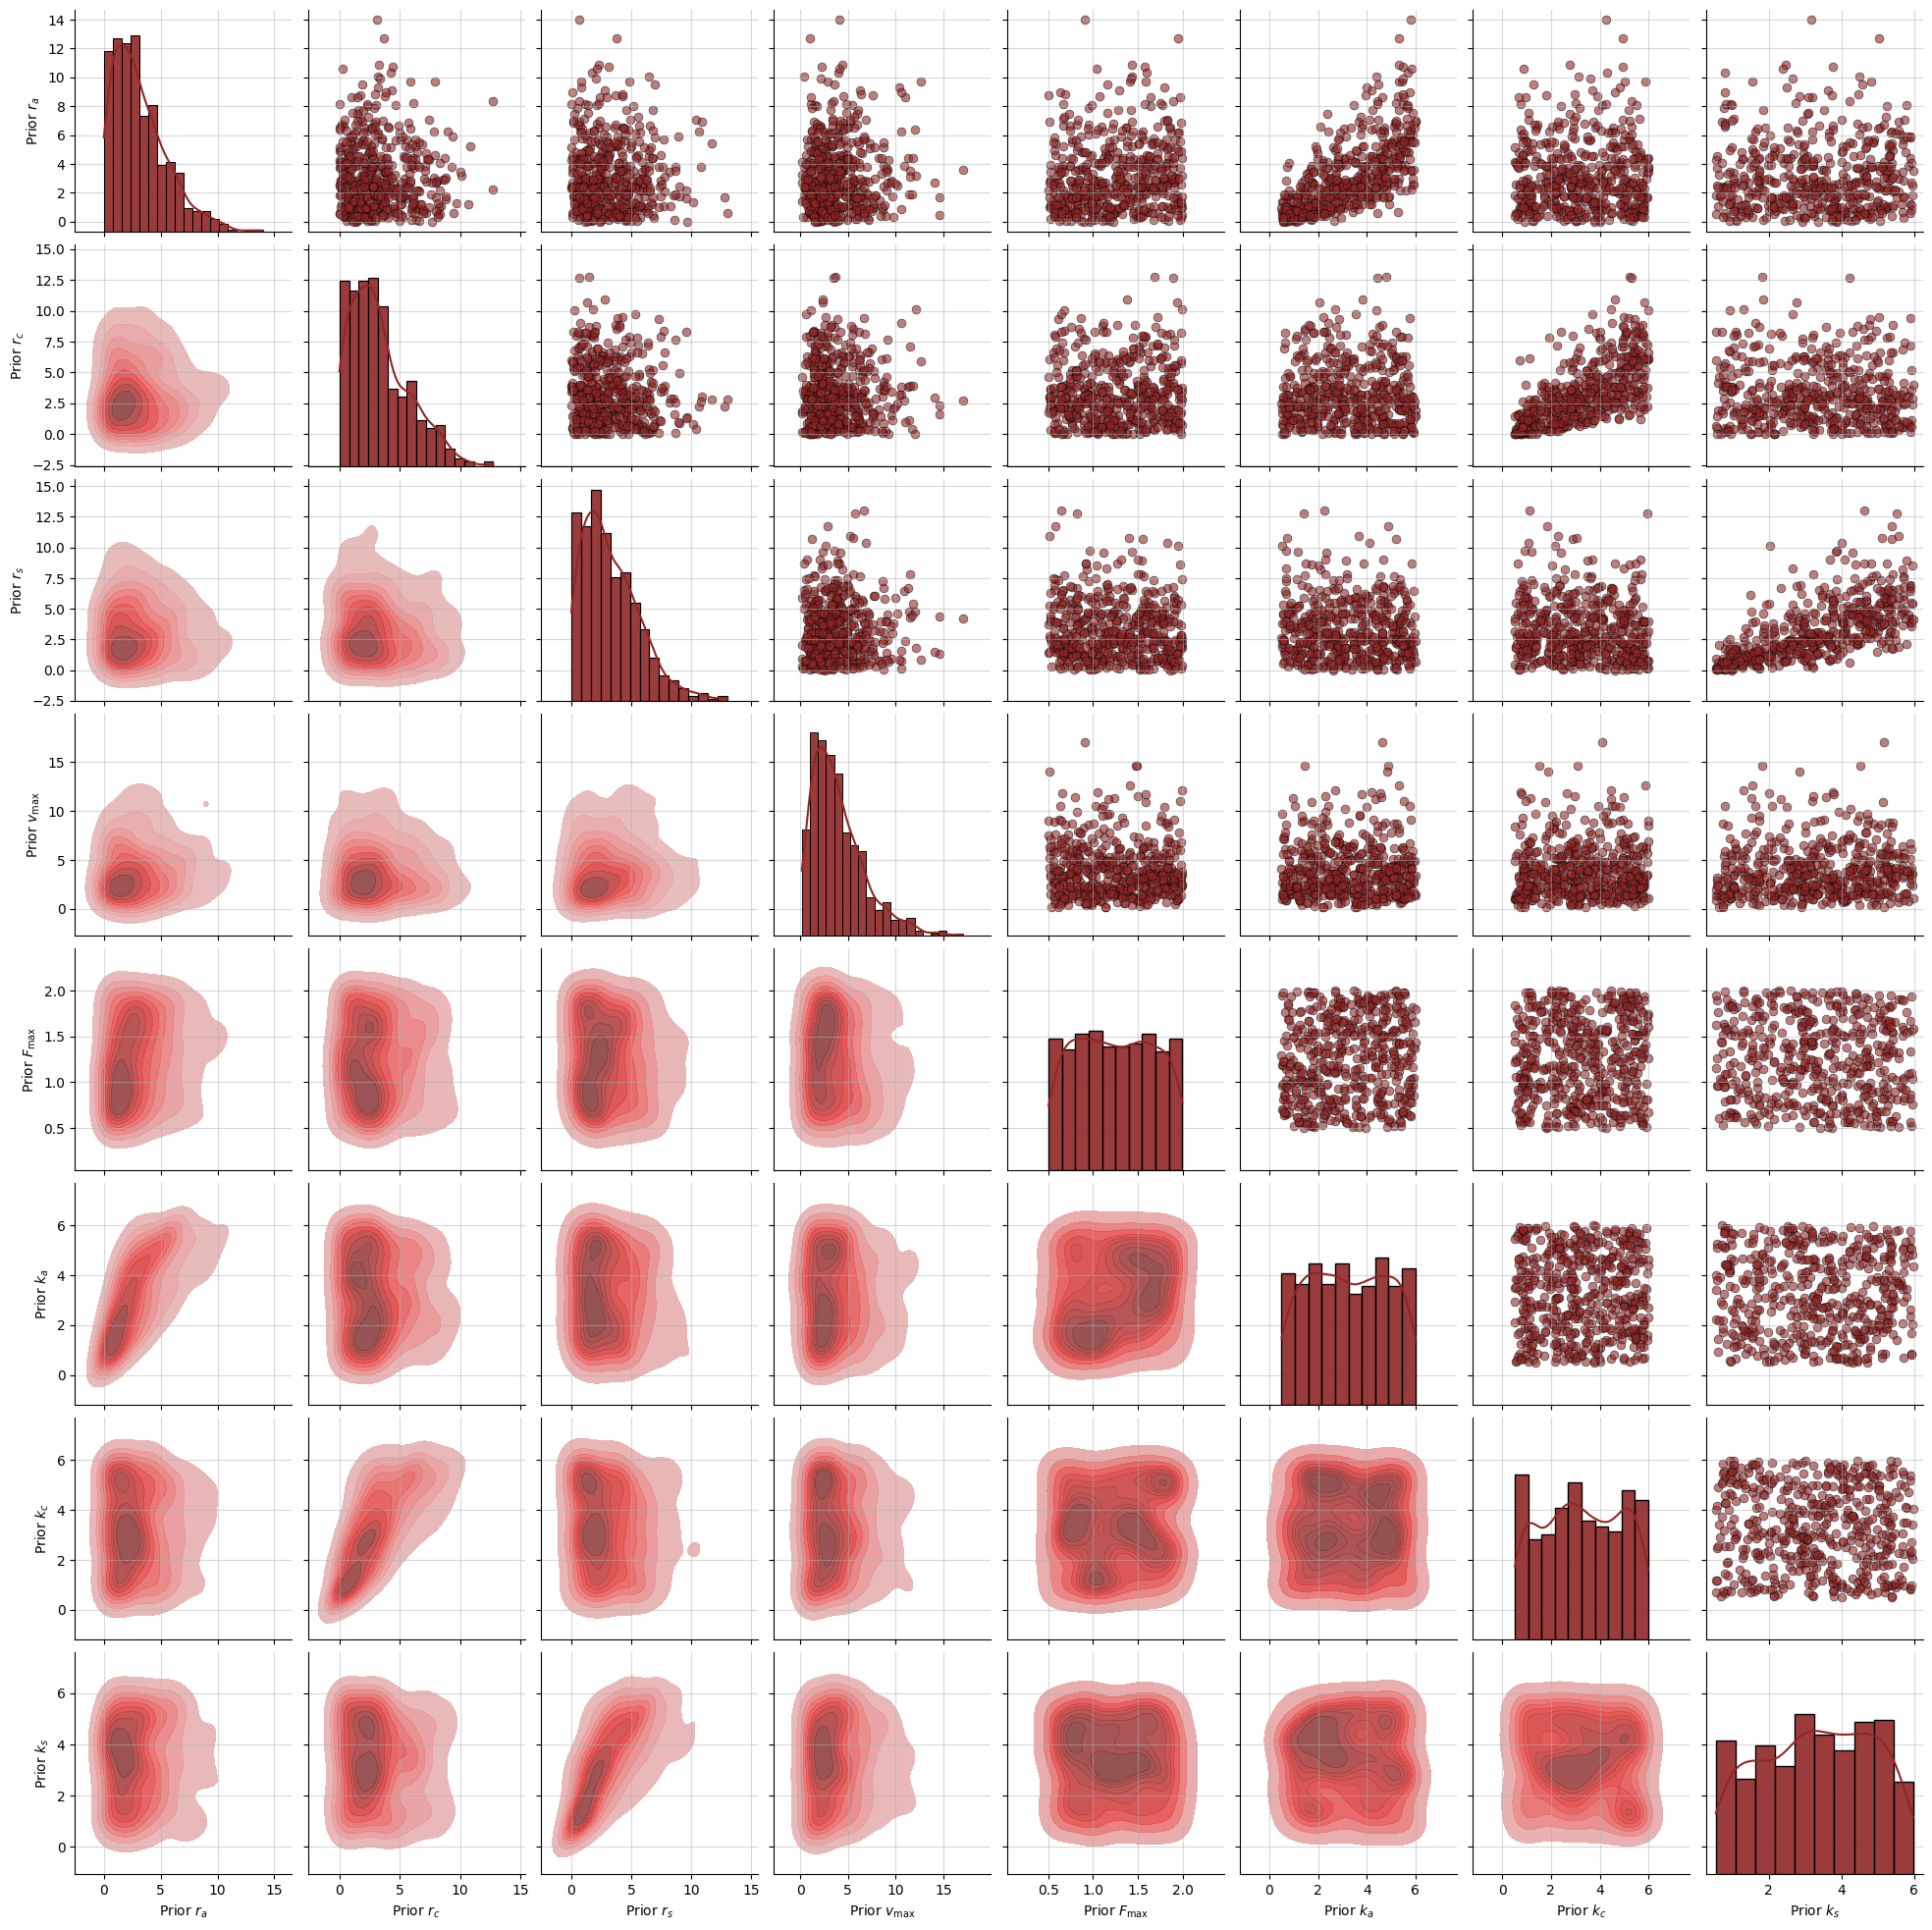

In [22]:
f = prior.plot_prior2d(n_samples=500)